# Structural MRI Data Preprocessing: CAT12 Pipeline | FreeSurfer Feature Set | Model Evaluation
## Libraries and AnatCL model

In [8]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import matplotlib.pyplot as plt
from anatcl import AnatCL
import torch.nn as nn
import torch.optim as optim
import os, random, numpy as np, torch
import glob
import subprocess
import json
from pathlib import Path
import time

## Paths

In [2]:
base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids"
subject_list_path = os.path.join(base_dir, "female_p_ages.txt")
subject_list = os.path.join(base_dir, "female_ids_with_T1w.txt")
output_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/preprocessed_output"
container_image = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"
boutiques_descriptor = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/descriptors/cat12_prepro.json"

print("CAT12 + Smoothing Pipeline")
print("-" * 100)
print(f"Base directory: {base_dir}")
print(f"Subject list (with ages): {subject_list_path}")
print(f"Subject list: {subject_list}")
print(f"Output directory: {output_dir}")
print(f"Container image: {container_image}")
print(f"Boutiques descriptor: {boutiques_descriptor}")
print()

CAT12 + Smoothing Pipeline
----------------------------------------------------------------------------------------------------
Base directory: /home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids
Subject list (with ages): /home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids/female_p_ages.txt
Subject list: /home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids/female_ids_with_T1w.txt
Output directory: /home/arelbaha/links/projects/rrg-glatard/arelbaha/preprocessed_output
Container image: /home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif
Boutiques descriptor: /home/arelbaha/links/projects/rrg-glatard/arelbaha/descriptors/cat12_prepro.json



## Visualizing Participant Raw T1w Image (Example) 

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

t1w_data = []
count = 0

with open(subject_list, 'r') as f:
    for line in f:
        subject_id = line.strip()
        subject_dir = os.path.join(base_dir, subject_id)

        if not os.path.exists(subject_dir):
            continue
            
        try:
            ses_folders = [f for f in os.listdir(subject_dir) if f.startswith("ses-")]
            if not ses_folders:
                continue
        except:
            continue

        found_t1 = False
        for ses in ses_folders:
            anat_path = os.path.join(subject_dir, ses, "anat")
            if not os.path.isdir(anat_path):
                continue

            for file in os.listdir(anat_path):
                if "T1w" in file and file.endswith(".nii"):
                    t1_path = os.path.join(anat_path, file)
                    output_subdir = os.path.join(output_dir, subject_id)
                    os.makedirs(output_subdir, exist_ok=True)
                    
                    t1w_data.append({
                        'subject_id': subject_id,
                        'input_file': t1_path,
                        'output_dir': output_subdir
                    })
                    count += 1
                    found_t1 = True
                    break

            if found_t1:
                break

first_subject = t1w_data[0]
img = nib.load(first_subject['input_file'])
data = img.get_fdata()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(data[data.shape[0]//2, :, :], cmap='gray')
plt.title(f"Sagittal: {first_subject['subject_id']}")

plt.subplot(1, 3, 2)
plt.imshow(data[:, data.shape[1]//2, :], cmap='gray')
plt.title("Coronal")

plt.subplot(1, 3, 3)
plt.imshow(data[:, :, data.shape[2]//2], cmap='gray')
plt.title("Axial")
plt.show()

## Preprocessing

In [27]:
%load_ext slurm_magic

In [ ]:
#Downloading the Container

!module load apptainer

from boutiques import bosh
import boutiques.descriptor2func

bosh(["exec", "prepare", boutiques_descriptor, "--imagepath", "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"])
cat12 = boutiques.descriptor2func.function(boutiques_descriptor)


In [ ]:
%%writefile ~/links/projects/rrg-glatard/arelbaha/hbn_bids/cat12_preprocessing.py

import os
import glob
import boutiques
from boutiques import bosh
from boutiques.descriptor2func import function

#Downloading Container Part + Paths
boutiques_descriptor = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/descriptors/cat12_prepro.json"
base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids"
output_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/preprocessed_output"

bosh(["exec", "prepare", boutiques_descriptor, "--imagepath", "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"])
cat12 = boutiques.descriptor2func.function(boutiques_descriptor)

#Task ID Extraction
t1_nii_files = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "sub-*_T1w.nii"))
print(f"Found {len(t1_nii_files)} T1w files.")

task_id = int(os.environ["SLURM_ARRAY_TASK_ID"])

if task_id >= len(t1_nii_files) or task_id < 0:
    print(f"SLURM_ARRAY_TASK_ID={task_id} out of range")
    exit(1)

input_file = t1_nii_files[task_id]

path_parts = input_file.split(os.sep)
subject_id = next((part for part in path_parts if part.startswith("sub-")), None)

if subject_id is None:
        print(f"Could not find subject ID in path: {input_file}")
        exit(1)

filename = os.path.basename(input_file)

subject_output_dir = os.path.join(output_dir, subject_id)
os.makedirs(subject_output_dir, exist_ok=True)

print(f"Processing SLURM_ARRAY_TASK_ID ={task_id} -> file: {filename} (subject: {subject_id})")

result = cat12('--imagepath=/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif', 
                   input_file=input_file, 
                   output_dir=subject_output_dir)

result_dict = vars(result)
print("Available result keys:", result_dict.keys())
print("\nExit code:", result_dict.get("exit_code"))
print("\nStdout:\n", result_dict.get ("stdout" ))
print("\nStderr:\n", result_dict.get ("stderr"))
print("\nOutput files:\n", result_dict.get("output_files"))

In [ ]:
%%sbatch --array=761-860
#!/bin/bash
#SBATCH --job-name=CAT12_preproc
#SBATCH --account=rrg-glatard
#SBATCH --mem=8G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=CAT12_preproc_%A_%a.out
#SBATCH --error=CAT12_preproc_%A_%a.err
#SBATCH --time=1:0:0

source ~/.venvs/jupyter_py3/bin/activate

module load apptainer

cd ~/links/projects/rrg-glatard/arelbaha/hbn_bids #Location of preprocessing data and script

echo "Running task ID: $SLURM_ARRAY_TASK_ID"

python cat12_preprocessing.py

## Checking Preprocessed Data 

In [ ]:
data = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "mri", "s6mwp1sub-*_T1w.nii"))

first_subject = data[0]

img = nib.load(first_subject)
data = img.get_fdata()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(data[data.shape[0] // 2, :, :], cmap='gray')
plt.title(f"Sagittal: sub-{subject_id}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(data[:, data.shape[1] // 2, :], cmap='gray')
plt.title("Coronal")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
plt.title("Axial")
plt.axis('off')

plt.tight_layout()
plt.show()

## Using Preprocessed Data and Linear Probing

In [26]:
%%writefile ~/links/projects/rrg-glatard/arelbaha/hbn_bids/brain_age_prediction.py

import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import nibabel as nib
import matplotlib.pyplot as plt
from anatcl import AnatCL
from sklearn.model_selection import train_test_split, KFold

#Get Ages

base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha"
subject_list_path = os.path.join(base_dir, "hbn_bids", "female_p_ages.txt")
subject_list_QC = os.path.join(base_dir, "HBN_FreeSurfer", "extracted_subs.txt")

id_age_dict = {}
with open(subject_list_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            sid, age = parts
            id_age_dict[sid] = float(age)


extracted_subject_ids = []
with open(subject_list_QC, 'r') as f:
    for line in f:
        subject_id = line.strip()
        if subject_id:
            extracted_subject_ids.append(subject_id)


data = []
matched_subjects = []
ages = []

for subject_id_with_prefix in extracted_subject_ids:
    pattern = os.path.join(base_dir, "hbn_bids", subject_id_with_prefix, "ses-*", "anat", "mri", f"s6mwp1{subject_id_with_prefix}_ses-*_T1w.nii")
    files = glob.glob(pattern)
    
    for file_path in files:
        subject_id_no_prefix = subject_id_with_prefix.replace("sub-", "")
        if subject_id_no_prefix in id_age_dict:
            data.append(file_path)
            matched_subjects.append(file_path)
            ages.append(id_age_dict[subject_id_no_prefix])

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

class CAT12VBMDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = nib.load(self.data[idx]).get_fdata()
        if self.transform:
            img = self.transform(img)
        img = img.unsqueeze(0)
        if self.labels is None:
            return img, os.path.basename(self.data[idx])
        return img, torch.tensor(self.labels[idx], dtype=torch.float32)

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x.copy()).float()),
    transforms.Normalize(mean=0.0, std=1.0),
])

device = "cuda" if torch.cuda.is_available() else "cpu"

# Encoder (frozen)
path = "/home/arelbaha/.venvs/jupyter_py3/bin/fold0.pth"
encoder = AnatCL(descriptor="global", fold=0, pretrained=False).to(device).eval()
checkpoint = torch.load(path, map_location=device, weights_only=False)
encoder.backbone.load_state_dict(checkpoint['model'])

for p in encoder.parameters():
    p.requires_grad = False

#Extracting Embeddings
ds = CAT12VBMDataset(data, ages, transform)
dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)

with torch.no_grad():
    X, y = [], []
    for vol, label in dl:
        vol = vol.to(device)
        feat = encoder(vol)
        X.append(feat.squeeze(0).cpu())
        y.append(label.squeeze(0).cpu())

X = torch.cat(X)
y = torch.cat(y)

N = len(X)
test_size = int(0.1 * N)
indices = np.arange(N)
np.random.seed(SEED)
np.random.shuffle(indices)

test_indices = indices[:test_size]
cv_indices = indices[test_size:]

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

alphas = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
num_epochs = 300
batch_size = 32

class BrainAgeHead(nn.Module):
    def __init__(self, input_dim=512):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x).squeeze(1)

criterion = nn.L1Loss()

val_mae_results = {alpha: [] for alpha in alphas}

for fold, (train_idx_rel, val_idx_rel) in enumerate(kf.split(cv_indices)):
    print(f"Fold {fold+1}")
    
    train_idx = cv_indices[train_idx_rel]
    val_idx = cv_indices[val_idx_rel]
    
    for alpha in alphas:
        n_train_downsample = int(alpha * len(train_idx))
        np.random.seed(SEED)
        train_idx_downsampled = np.random.choice(train_idx, size=n_train_downsample, replace=False)

        train_sampler = SubsetRandomSampler(train_idx_downsampled)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=val_sampler)

        model = BrainAgeHead().to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        model.train()
        for epoch in range(num_epochs):
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        val_mae = np.mean(val_losses)
        val_mae_results[alpha].append(val_mae)
        print(f"  Alpha {alpha}: Val MAE = {val_mae:.4f}")

avg_val_mae = {alpha: np.mean(val_mae_results[alpha]) for alpha in alphas}
best_alpha = min(avg_val_mae, key=avg_val_mae.get)
print(f"Best alpha: {best_alpha} with avg val MAE: {avg_val_mae[best_alpha]:.4f}")

n_train_full = int(best_alpha * len(cv_indices))
np.random.seed(SEED)
train_full_idx = np.random.choice(cv_indices, size=n_train_full, replace=False)
train_full_sampler = SubsetRandomSampler(train_full_idx)
full_train_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=train_full_sampler)

final_model = BrainAgeHead().to(device)
optimizer = optim.Adam(final_model.parameters(), lr=1e-3)

final_model.train()
for epoch in range(num_epochs):
    for xb, yb in full_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()


test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=test_sampler)

final_model.eval()
test_losses = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = final_model(xb)
        loss = criterion(preds, yb)
        test_losses.append(loss.item())

test_mae = np.mean(test_losses)
print(f"Test MAE with best alpha {best_alpha}: {test_mae:.4f}")

y_test = y[test_indices].cpu()
preds_test = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = final_model(xb)
        preds_test.append(preds.cpu())
preds_test = torch.cat(preds_test)

Overwriting /home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids/brain_age_prediction.py


In [28]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=brain_age_prediction
#SBATCH --account=rrg-glatard
#SBATCH --mem=16G
#SBATCH --cpus-per-task=4
#SBATCH --nodes=1
#SBATCH --output=result_age.out
#SBATCH --error=result_age.err
#SBATCH --time=1:00:00

source ~/.venvs/jupyter_py3/bin/activate
cd ~/links/projects/rrg-glatard/arelbaha/hbn_bids
python brain_age_prediction.py

('Submitted batch job 2172951\n',
 'sbatch: NOTE: Your memory request of 16384.0M was likely submitted as 16.0G. Please note that Slurm interprets memory requests denominated in G as multiples of 1024M, not 1000M.\n')

## AnatCL Linear Regression | Performance Analysis

Best alpha: 1.0 with avg val MAE: 2.5077
Test MAE with best alpha 1.0: 2.009

Approximate number of training examples per alpha:
Alpha 0.01: 6 examples
Alpha 0.05: 30 examples
Alpha 0.1: 61 examples
Alpha 0.25: 154 examples
Alpha 0.5: 309 examples
Alpha 0.75: 464 examples
Alpha 1.0: 619 examples


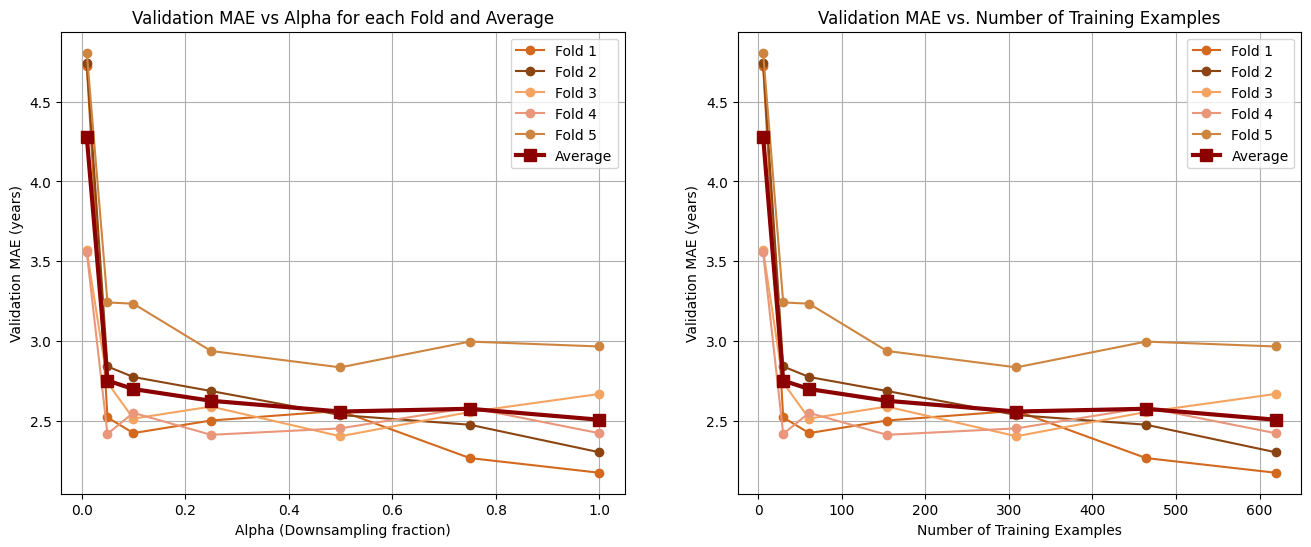

In [73]:
import matplotlib.pyplot as plt
import numpy as np

fold_maes = {
    1: {0.01: 4.7256, 0.05: 2.5220, 0.1: 2.4238, 0.25: 2.5027, 0.5: 2.5637, 0.75: 2.2675, 1.0: 2.1756},
    2: {0.01: 4.7425, 0.05: 2.8413, 0.1: 2.7753, 0.25: 2.6875, 0.5: 2.5370, 0.75: 2.4763, 1.0: 2.3040},
    3: {0.01: 3.5681, 0.05: 2.7402, 0.1: 2.5146, 0.25: 2.5899, 0.5: 2.4041, 0.75: 2.5560, 1.0: 2.6689},
    4: {0.01: 3.5552, 0.05: 2.4187, 0.1: 2.5508, 0.25: 2.4131, 0.5: 2.4535, 0.75: 2.5840, 1.0: 2.4234},
    5: {0.01: 4.8067, 0.05: 3.2424, 0.1: 3.2345, 0.25: 2.9384, 0.5: 2.8356, 0.75: 2.9971, 1.0: 2.9665},
}

alphas = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
folds = sorted(fold_maes.keys())

val_maes_per_alpha = {alpha: [] for alpha in alphas}
for fold in folds:
    for alpha in alphas:
        val_maes_per_alpha[alpha].append(fold_maes[fold][alpha])

avg_val_maes = {alpha: np.mean(val_maes_per_alpha[alpha]) for alpha in alphas}

N = 859
test_size = int(0.1 * N)
cv_indices_size = N - test_size 
train_idx_size = int(cv_indices_size * (4/5))
train_examples_per_alpha = {alpha: int(alpha * train_idx_size) for alpha in alphas}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fold_colors = ['chocolate', 'saddlebrown', 'sandybrown', 'darksalmon', 'peru']

for i, fold in enumerate(folds):
    maes = [fold_maes[fold][alpha] for alpha in alphas]
    ax1.plot(alphas, maes, marker='o', label=f'Fold {fold}', color=fold_colors[i])
avg_maes = [avg_val_maes[alpha] for alpha in alphas]
ax1.plot(alphas, avg_maes, marker='s', color='darkred', linewidth=3, label='Average', markersize=8)
ax1.set_xlabel("Alpha (Downsampling fraction)")
ax1.set_ylabel("Validation MAE (years)")
ax1.set_title("Validation MAE vs Alpha for each Fold and Average")
ax1.legend()
ax1.grid(True)

x_vals = [train_examples_per_alpha[alpha] for alpha in alphas]
for i, fold in enumerate(folds):
    maes = [fold_maes[fold][alpha] for alpha in alphas]
    ax2.plot(x_vals, maes, marker='o', label=f'Fold {fold}', color=fold_colors[i])
ax2.plot(x_vals, avg_maes, marker='s', color='darkred', linewidth=3, label='Average', markersize=8)
ax2.set_xlabel("Number of Training Examples")
ax2.set_ylabel("Validation MAE (years)")
ax2.set_title("Validation MAE vs. Number of Training Examples")
ax2.legend()
ax2.grid(True)

best_alpha = min(avg_val_maes, key=avg_val_maes.get)
best_avg_val_mae = avg_val_maes[best_alpha]

test_maes = {
    0.5: 2.0084,
    1.0: 2.0090
}
test_mae = test_maes.get(best_alpha, "N/A")

print(f"Best alpha: {best_alpha} with avg val MAE: {best_avg_val_mae:.4f}")
print(f"Test MAE with best alpha {best_alpha}: {test_mae}")

print("\nApproximate number of training examples per alpha:")
for alpha in alphas:
    print(f"Alpha {alpha}: {train_examples_per_alpha[alpha]} examples")

In [2]:
%%writefile ~/links/projects/rrg-glatard/arelbaha/hbn_bids/comparison.py

import os
import glob
import random
import fnmatch
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import nibabel as nib
from anatcl import AnatCL
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

#Data paths
base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha"
base_dir_p = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/HBN_FreeSurfer"

#Load age data
subject_list_path = os.path.join(base_dir, "hbn_bids", "female_p_ages.txt")
id_age_dict = {}
with open(subject_list_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            sid, age = parts
            id_age_dict[sid] = float(age)

#Load QC'd subjects
subject_list_QC = os.path.join(base_dir_p, "extracted_subs.txt")
extracted_subject_ids = []
with open(subject_list_QC, 'r') as f:
    for line in f:
        subject_id = line.strip()
        if subject_id:
            extracted_subject_ids.append(subject_id)

print(f"Loaded {len(id_age_dict)} ages and {len(extracted_subject_ids)} QC'd subjects")

# Load FreeSurfer ROI volume data
freesurfer_dir = os.path.join(base_dir_p, "freesurfer")
parcellation_filter = "Schaefer2018_400Parcels_17Networks_order"
surf_area_vectors = {} 
thick_avg_vectors = {}
all_subject_data = {}

for dirpath, dirnames, filenames in os.walk(freesurfer_dir):
    rel_path = os.path.relpath(dirpath, freesurfer_dir)
    parts = rel_path.split(os.sep)
    
    if len(parts) > 0:
        subject_id = parts[0]
    else:
        continue
    
    if subject_id in extracted_subject_ids:
        for filename in filenames:
            if fnmatch.fnmatch(filename, '*regionsurfacestats.tsv'):
                full_path = os.path.join(dirpath, filename)
                
                try:
                    df = pd.read_csv(full_path, sep='\t')
                    filtered_df = df[df["atlas"] == parcellation_filter]
                    
                    if not filtered_df.empty:
                        if "StructName" in filtered_df.columns:
                            filtered_df = filtered_df.sort_values("StructName")
                        
                        if "SurfArea" in filtered_df.columns and "ThickAvg" in filtered_df.columns:
                            surf_area_vector = filtered_df["SurfArea"].values
                            thick_avg_vector = filtered_df["ThickAvg"].values
                            surf_area_vectors[subject_id] = surf_area_vector
                            thick_avg_vectors[subject_id] = thick_avg_vector
                            all_subject_data[subject_id] = len(filtered_df)
                        
                except Exception as e:
                    print(f"Error reading {full_path}: {e}")

#ROI volumes feature matrix
common_fs_subjects = set(surf_area_vectors.keys()) & set(thick_avg_vectors.keys())
roi_subjects = sorted([s for s in common_fs_subjects if all_subject_data[s] >= 400])
roi_features = []
roi_ages = []

for subject_id in roi_subjects:
    subject_id_no_prefix = subject_id.replace("sub-", "")
    if subject_id_no_prefix in id_age_dict:
        surf_features = surf_area_vectors[subject_id][:400]
        thick_features = thick_avg_vectors[subject_id][:400]
        combined_features = np.concatenate([surf_features, thick_features])
        roi_features.append(combined_features)
        roi_ages.append(id_age_dict[subject_id_no_prefix])

roi_features = np.array(roi_features)
roi_ages = np.array(roi_ages)
print(f"ROI volumes: {len(roi_ages)} subjects, {roi_features.shape[1]} features")

#Load VBM data for AnatCL
vbm_data = []
vbm_subjects = []
anatcl_ages = []

for subject_id_with_prefix in extracted_subject_ids:
    pattern = os.path.join(base_dir, "hbn_bids", subject_id_with_prefix, "ses-*", "anat", "mri", f"s6mwp1{subject_id_with_prefix}_ses-*_T1w.nii")
    files = glob.glob(pattern)
    
    for file_path in files:
        subject_id_no_prefix = subject_id_with_prefix.replace("sub-", "")
        if subject_id_no_prefix in id_age_dict:
            vbm_data.append(file_path)
            vbm_subjects.append(subject_id_with_prefix)
            anatcl_ages.append(id_age_dict[subject_id_no_prefix])

print(f"AnatCL: Found {len(vbm_data)} subjects with VBM data")

class CAT12VBMDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = nib.load(self.data[idx]).get_fdata()
        if self.transform:
            img = self.transform(img)
        img = img.unsqueeze(0)
        return img, torch.tensor(self.labels[idx] if self.labels else 0, dtype=torch.float32)

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x.copy()).float()),
    transforms.Normalize(mean=0.0, std=1.0),
])

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#Load AnatCL encoder
path = "/home/arelbaha/.venvs/jupyter_py3/bin/fold0.pth"
encoder = AnatCL(descriptor="global", fold=0, pretrained=False).to(device).eval()
checkpoint = torch.load(path, map_location=device, weights_only=False)
encoder.backbone.load_state_dict(checkpoint['model'])
for p in encoder.parameters():
    p.requires_grad = False

#Extract AnatCL embeddings
ds = CAT12VBMDataset(vbm_data, anatcl_ages, transform)
dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)

with torch.no_grad():
    anatcl_features = []
    for i, (vol, _) in enumerate(dl):
        if i % 10 == 0:
            print(f"Processing batch {i+1}/{len(dl)}")
        vol = vol.to(device)
        feat = encoder(vol)
        anatcl_features.append(feat.cpu())

anatcl_features = torch.cat(anatcl_features).numpy()
anatcl_ages = np.array(anatcl_ages)
print(f"AnatCL: {len(anatcl_ages)} subjects, {anatcl_features.shape[1]} features")

#Matching subjects between datasets
roi_subject_dict = {roi_subjects[i].replace("sub-", ""): i for i in range(len(roi_subjects))}
anatcl_subject_dict = {vbm_subjects[i].replace("sub-", ""): i for i in range(len(vbm_subjects))}
common_subject_ids = set(roi_subject_dict.keys()) & set(anatcl_subject_dict.keys())
common_subject_ids = sorted(list(common_subject_ids))
print(f"Common subjects between both datasets: {len(common_subject_ids)}")

matched_roi_features = []
matched_anatcl_features = []
matched_ages = []

for subject_id in common_subject_ids:
    roi_idx = roi_subject_dict[subject_id]
    anatcl_idx = anatcl_subject_dict[subject_id]
    
    matched_roi_features.append(roi_features[roi_idx])
    matched_anatcl_features.append(anatcl_features[anatcl_idx])
    matched_ages.append(id_age_dict[subject_id])

matched_roi_features = np.array(matched_roi_features)
matched_anatcl_features = np.array(matched_anatcl_features)
matched_ages = np.array(matched_ages)

#Cross-validation training
alphas = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
roi_results = {alpha: [] for alpha in alphas}
anatcl_results = {alpha: [] for alpha in alphas}

roi_fold_results = {alpha: [] for alpha in alphas}  
anatcl_fold_results = {alpha: [] for alpha in alphas}

for fold, (train_idx, val_idx) in enumerate(kf.split(matched_roi_features)):
    print(f"\nFold {fold+1}")
    
    for alpha in alphas:
        n_train = int(alpha * len(train_idx))
        if n_train < 5:
            n_train = min(5, len(train_idx))
        
        np.random.seed(SEED + fold)
        train_subsample_idx = np.random.choice(train_idx, n_train, replace=False)
        
        val_roi = matched_roi_features[val_idx]
        val_anatcl = matched_anatcl_features[val_idx]
        y_val = matched_ages[val_idx]
        
        train_roi = matched_roi_features[train_subsample_idx]
        train_anatcl = matched_anatcl_features[train_subsample_idx]
        y_train = matched_ages[train_subsample_idx]
        
        #Feature scaling
        scaler_roi = StandardScaler()
        scaler_anatcl = StandardScaler()
        
        train_roi_scaled = scaler_roi.fit_transform(train_roi)
        val_roi_scaled = scaler_roi.transform(val_roi)
        
        train_anatcl_scaled = scaler_anatcl.fit_transform(train_anatcl)
        val_anatcl_scaled = scaler_anatcl.transform(val_anatcl)
        
        #Train ROI volumes+RF
        rf_roi = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=SEED, n_jobs=1)
        rf_roi.fit(train_roi_scaled, y_train)
        roi_pred = rf_roi.predict(val_roi_scaled)
        roi_mae = mean_absolute_error(y_val, roi_pred)
        roi_results[alpha].append(roi_mae)
        roi_fold_results[alpha].append(roi_mae)
        
        #Train AnatCL+RF
        rf_anatcl = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=SEED, n_jobs=1)
        rf_anatcl.fit(train_anatcl_scaled, y_train)
        anatcl_pred = rf_anatcl.predict(val_anatcl_scaled)
        anatcl_mae = mean_absolute_error(y_val, anatcl_pred)
        anatcl_results[alpha].append(anatcl_mae)
        anatcl_fold_results[alpha].append(anatcl_mae)
        
        print(f"  α={alpha}: ROI MAE={roi_mae:.4f}, AnatCL MAE={anatcl_mae:.4f}")

#Save results
results_data = []
for alpha in alphas:
    roi_avg = np.mean(roi_results[alpha])
    anatcl_avg = np.mean(anatcl_results[alpha])
    diff = anatcl_avg - roi_avg
    print(f"{alpha}\t{roi_avg:.4f}\t\t{anatcl_avg:.4f}\t\t{diff:+.4f}")
    
    results_data.append({
        'alpha': alpha,
        'roi_volumes_mae': roi_avg,
        'anatcl_mae': anatcl_avg,
        'difference': diff,
        'training_subjects': int(alpha * len(matched_ages) * 0.8)
    })

results_df = pd.DataFrame(results_data)
results_df.to_csv('comparison_results.csv', index=False)

#Performance comparison plot
training_subjects = [int(alpha * len(matched_ages) * 0.8) for alpha in alphas]
plt.figure(figsize=(12, 8))

#Individual fold results
for alpha_idx, alpha in enumerate(alphas):
    for fold_idx in range(5):
        roi_fold_mae = roi_fold_results[alpha][fold_idx]
        anatcl_fold_mae = anatcl_fold_results[alpha][fold_idx]
        
        plt.scatter(training_subjects[alpha_idx], roi_fold_mae, 
                   color='blue', alpha=0.3, s=20, label='_nolegend_')
        plt.scatter(training_subjects[alpha_idx], anatcl_fold_mae, 
                   color='red', alpha=0.3, s=20, label='_nolegend_')

#Mean curves
roi_means = [np.mean(roi_results[alpha]) for alpha in alphas]
anatcl_means = [np.mean(anatcl_results[alpha]) for alpha in alphas]

plt.plot(training_subjects, roi_means, 'o-', linewidth=3, markersize=8, 
         label='ROI volumes + RF', color='blue')
plt.plot(training_subjects, anatcl_means, 's-', linewidth=3, markersize=8, 
         label='AnatCL + RF', color='red')

plt.xlabel('Number of Training Subjects', fontsize=14)
plt.ylabel('Mean Absolute Error (years)', fontsize=14) 
plt.title('Age Prediction Performance Comparison', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(training_subjects, [str(n) for n in training_subjects])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

#Pairwise correlation analysis
scaler_roi_corr = StandardScaler()
scaler_anatcl_corr = StandardScaler()
roi_scaled = scaler_roi_corr.fit_transform(matched_roi_features)
anatcl_scaled = scaler_anatcl_corr.fit_transform(matched_anatcl_features)

#Remove constant features
roi_var = np.var(roi_scaled, axis=0)
anatcl_var = np.var(anatcl_scaled, axis=0)

roi_valid_features = roi_var > 1e-10
anatcl_valid_features = anatcl_var > 1e-10

print(f"ROI volumes: {np.sum(~roi_valid_features)} constant features removed")
print(f"AnatCL: {np.sum(~anatcl_valid_features)} constant features removed")

roi_filtered = roi_scaled[:, roi_valid_features]
anatcl_filtered = anatcl_scaled[:, anatcl_valid_features]

#Equal number of features for comparison
max_dims = min(100, roi_filtered.shape[1], anatcl_filtered.shape[1])
roi_subset = roi_filtered[:, :max_dims]
anatcl_subset = anatcl_filtered[:, :max_dims]

print(f"Using {max_dims} features each for full pairwise correlation analysis")

#Create full correlation matrix
anatcl_feature_names = [f'AnatCL_{i:03d}' for i in range(max_dims)]
roi_feature_names = [f'ROI_{i:03d}' for i in range(max_dims)]

combined_features = np.concatenate([anatcl_subset, roi_subset], axis=1)
combined_df = pd.DataFrame(combined_features, 
                          columns=anatcl_feature_names + roi_feature_names)

full_correlation_matrix = combined_df.corr()

print(f"Full correlation matrix shape: {full_correlation_matrix.shape}")
print(f"Total correlations computed: {full_correlation_matrix.shape[0] * full_correlation_matrix.shape[1]}")

full_correlation_matrix.to_csv('full_pairwise_correlation_matrix.csv')

#Blocks
anatcl_block = full_correlation_matrix.iloc[:max_dims, :max_dims]
roi_block = full_correlation_matrix.iloc[max_dims:, max_dims:]
cross_block_anatcl_to_roi = full_correlation_matrix.iloc[:max_dims, max_dims:]
cross_block_roi_to_anatcl = full_correlation_matrix.iloc[max_dims:, :max_dims]

print(f"\nBlock Analysis:")
print(f"AnatCL-AnatCL correlations: mean |r| = {anatcl_block.abs().values.mean():.4f}")
print(f"ROI-ROI correlations: mean |r| = {roi_block.abs().values.mean():.4f}")
print(f"Cross-correlations: mean |r| = {cross_block_anatcl_to_roi.abs().values.mean():.4f}")

#Correlation matrix
fig, ax = plt.subplots(figsize=(16, 14))
im = ax.matshow(full_correlation_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)

cb = plt.colorbar(im, ax=ax, shrink=0.6)
cb.set_label('Correlation', fontsize=12)

ax.set_title(f'Pairwise Correlation Matrix\nAnatCL Embeddings (0-{max_dims-1}) | ROI Volumes ({max_dims}-{2*max_dims-1})', 
             fontsize=14, pad=20)

#Dividing lines
ax.axhline(y=max_dims-0.5, color='black', linewidth=3)
ax.axvline(x=max_dims-0.5, color='black', linewidth=3)

#Block labels
ax.text(max_dims//2, -8, 'AnatCL Features', ha='center', fontsize=12, weight='bold')
ax.text(max_dims + max_dims//2, -8, 'ROI Volume Features', ha='center', fontsize=12, weight='bold')
ax.text(-15, max_dims//2, 'AnatCL\nFeatures', ha='center', va='center', fontsize=12, weight='bold', rotation=90)
ax.text(-15, max_dims + max_dims//2, 'ROI Volume\nFeatures', ha='center', va='center', fontsize=12, weight='bold', rotation=90)

#Tick labels
tick_spacing = 20
all_ticks = range(0, 2*max_dims, tick_spacing)
tick_labels = [f'A{i}' if i < max_dims else f'R{i-max_dims}' for i in all_ticks]
ax.set_xticks(all_ticks)
ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)
ax.set_yticks(all_ticks)
ax.set_yticklabels(tick_labels, fontsize=8)

plt.tight_layout()
plt.savefig('full_pairwise_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

summary_stats = {
    'num_subjects': len(matched_ages),
    'age_range_min': float(matched_ages.min()),
    'age_range_max': float(matched_ages.max()),
    'features_used': max_dims,
    'anatcl_within_mean_corr': float(anatcl_block.abs().values.mean()),
    'roi_within_mean_corr': float(roi_block.abs().values.mean()),
    'cross_mean_corr': float(cross_block_anatcl_to_roi.abs().values.mean())
}

import json
with open('summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("\nGenerated files:")
print("- comparison_results.csv")
print("- full_pairwise_correlation_matrix.csv")
print("- full_pairwise_correlation_matrix.png")
print("- performance_comparison.png")
print("- summary_statistics.json")

Overwriting /home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids/comparison.py


In [4]:
import pandas as pd
import numpy as np
import json
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

#Base_Dir
results_path = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids/"

print("ROI Volumes + RF vs AnatCL Embeddings + RF")

results_df = pd.read_csv(os.path.join(results_path, 'comparison_results.csv'))
print("\nPerformance Comparison Table:")
display(results_df)

with open(os.path.join(results_path, 'summary_statistics.json'), 'r') as f:
    stats = json.load(f)
    
print(f"\nDataset Summary:")
print(f"- Total subjects: {stats['num_subjects']}")
print(f"- Age range: {stats['age_range_min']:.1f} - {stats['age_range_max']:.1f} years")
print(f"- Features analyzed: {stats['features_used']} each")

print(f"\nCorrelation Analysis:")
print(f"- AnatCL within-feature correlations: mean |r| = {stats['anatcl_within_mean_corr']:.4f}")
print(f"- ROI Volumes within-feature correlations: mean |r| = {stats['roi_within_mean_corr']:.4f}")
print(f"- Cross-method correlations: mean |r| = {stats['cross_mean_corr']:.4f}")

ROI Volumes + RF vs AnatCL Embeddings + RF

Performance Comparison Table:


,alpha,roi_volumes_mae,anatcl_mae,difference,training_subjects
0,0.01,3.174620,3.039766,-0.134855,6
1,0.05,2.868774,2.769904,-0.098870,30
2,0.10,2.783665,2.752192,-0.031473,60
3,0.25,2.621452,2.680612,0.059161,150
4,0.50,2.452820,2.612458,0.159638,300
5,0.75,2.367763,2.594317,0.226553,450
6,1.00,2.340326,2.599379,0.259053,600



Dataset Summary:
- Total subjects: 750
- Age range: 5.0 - 21.9 years
- Features analyzed: 100 each

Correlation Analysis:
- AnatCL within-feature correlations: mean |r| = 0.3919
- ROI Volumes within-feature correlations: mean |r| = 0.3017
- Cross-method correlations: mean |r| = 0.2620



Performance Comparison:


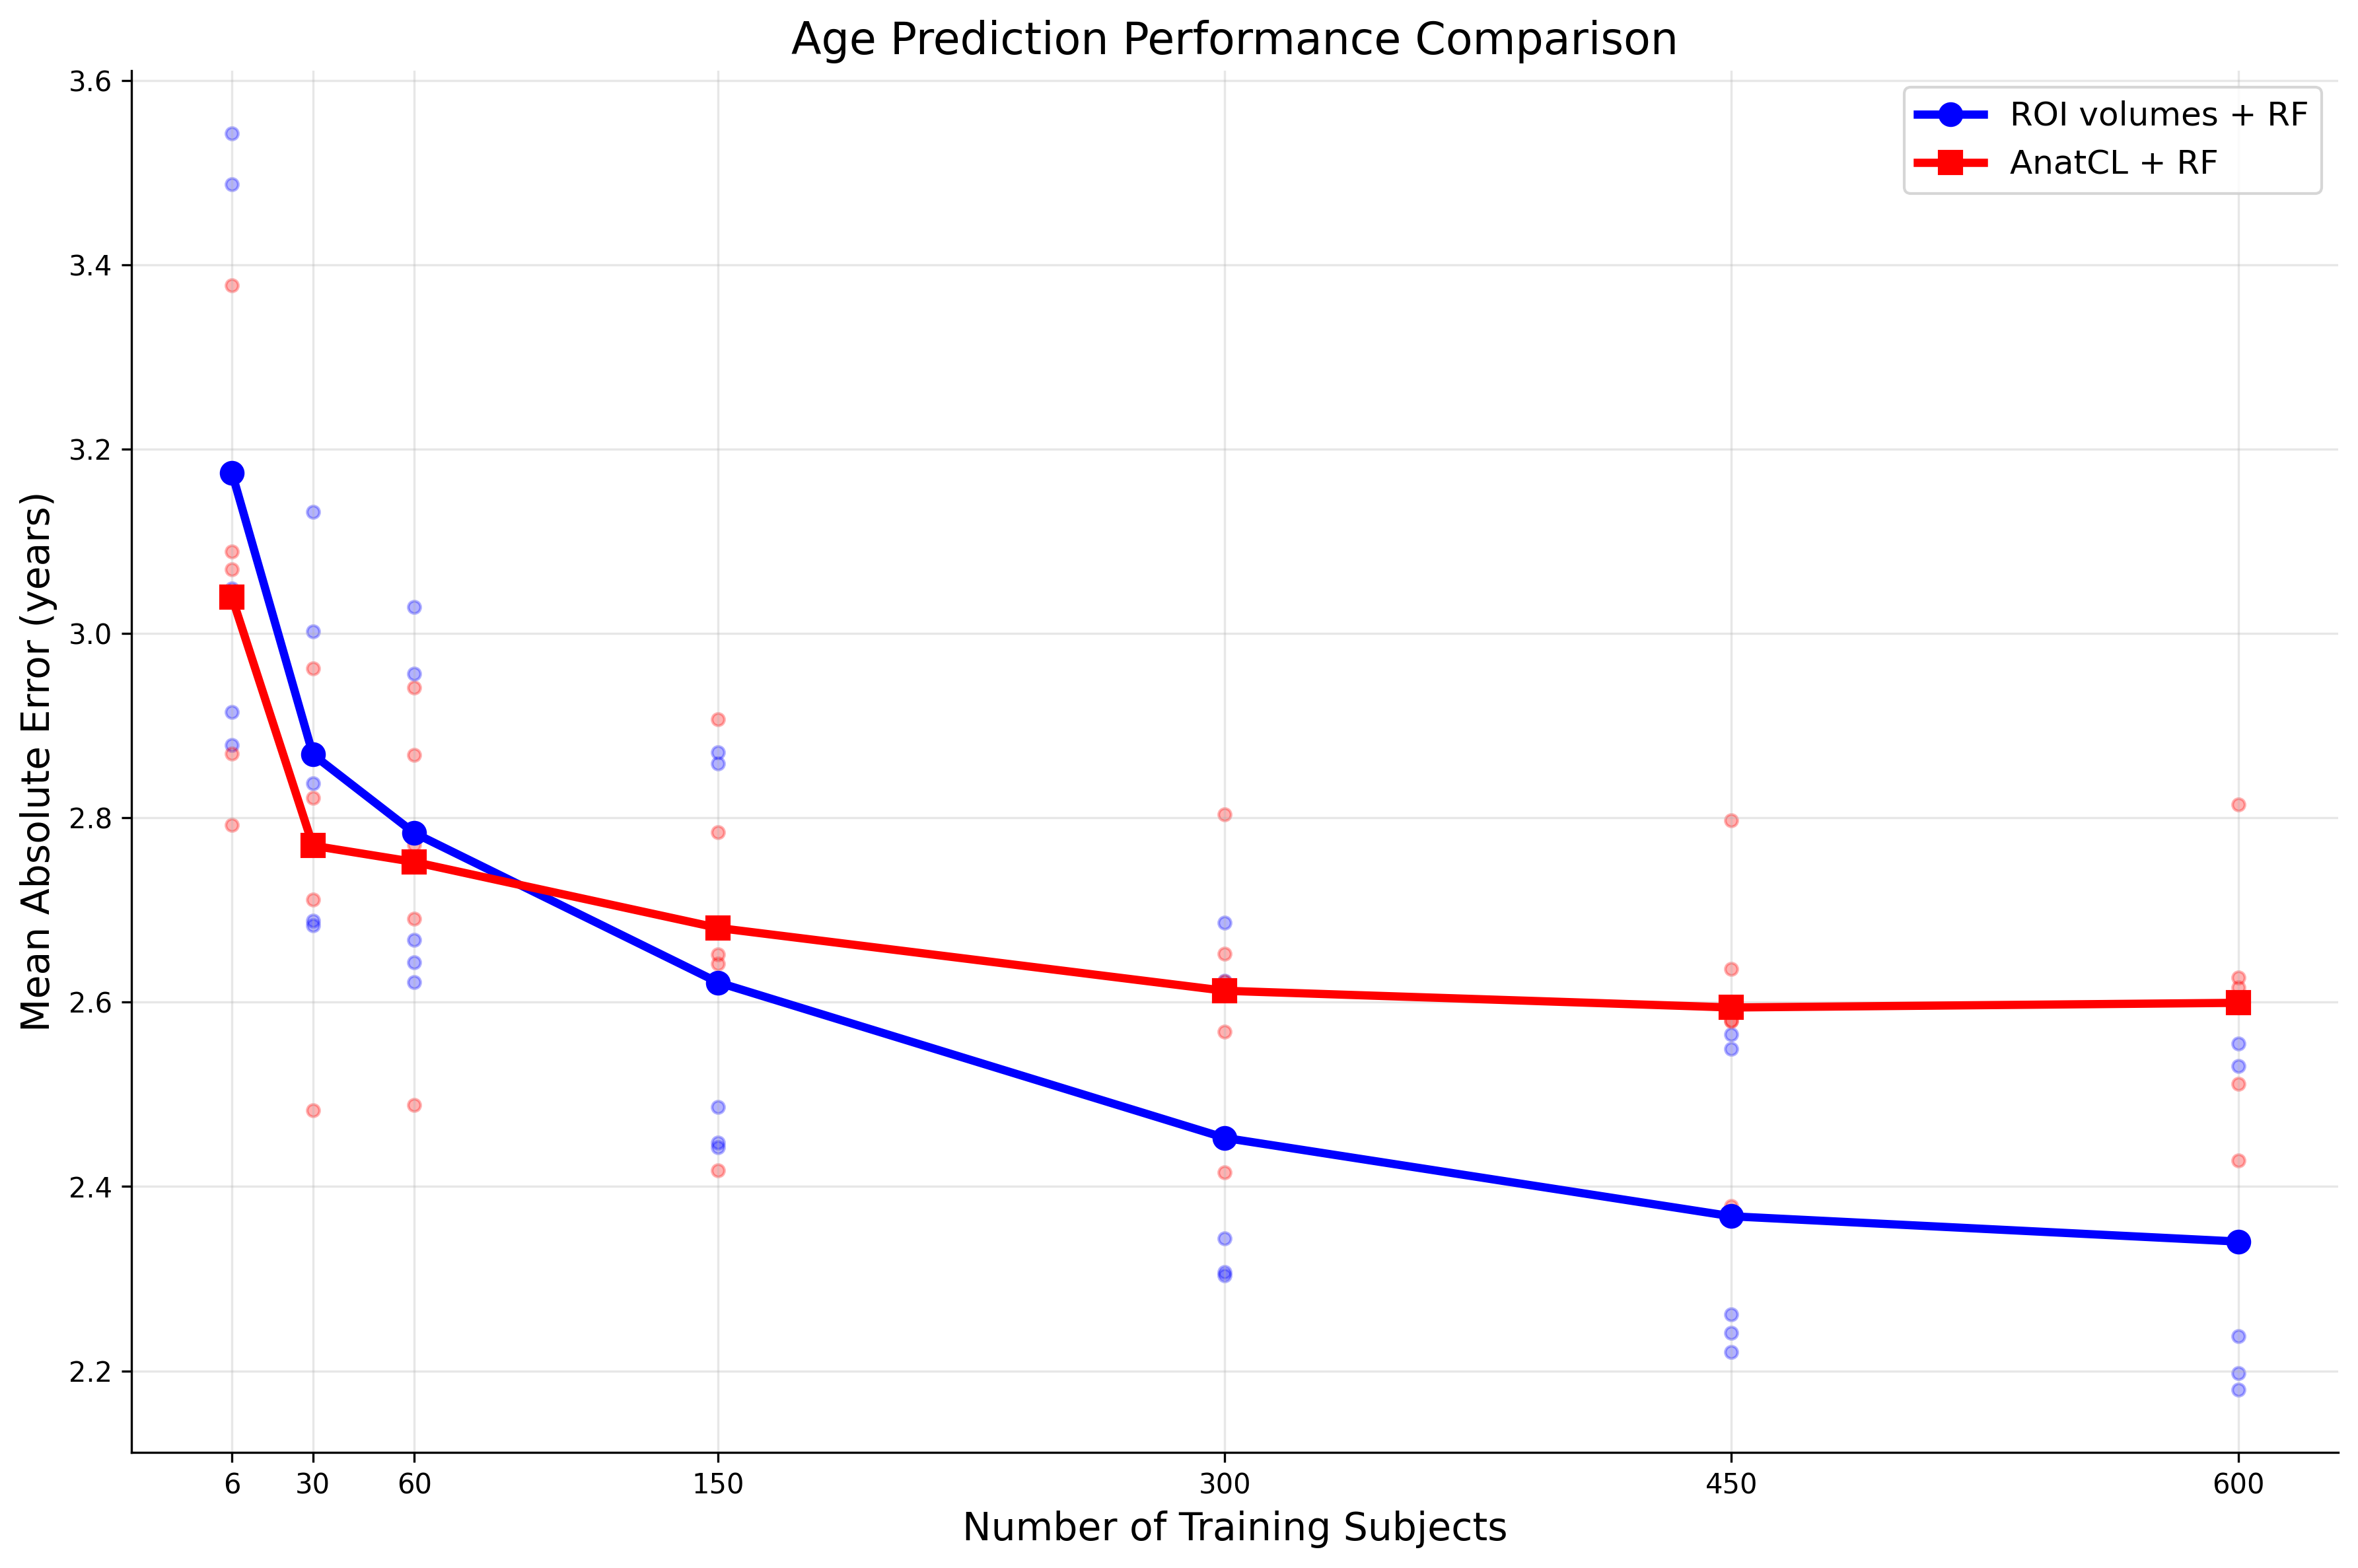

In [5]:
#Performance comparison plot
print("\nPerformance Comparison:")
display(Image(os.path.join(results_path, 'performance_comparison.png')))


Correlation Matrix:
Shows within-feature-set and cross-method correlations


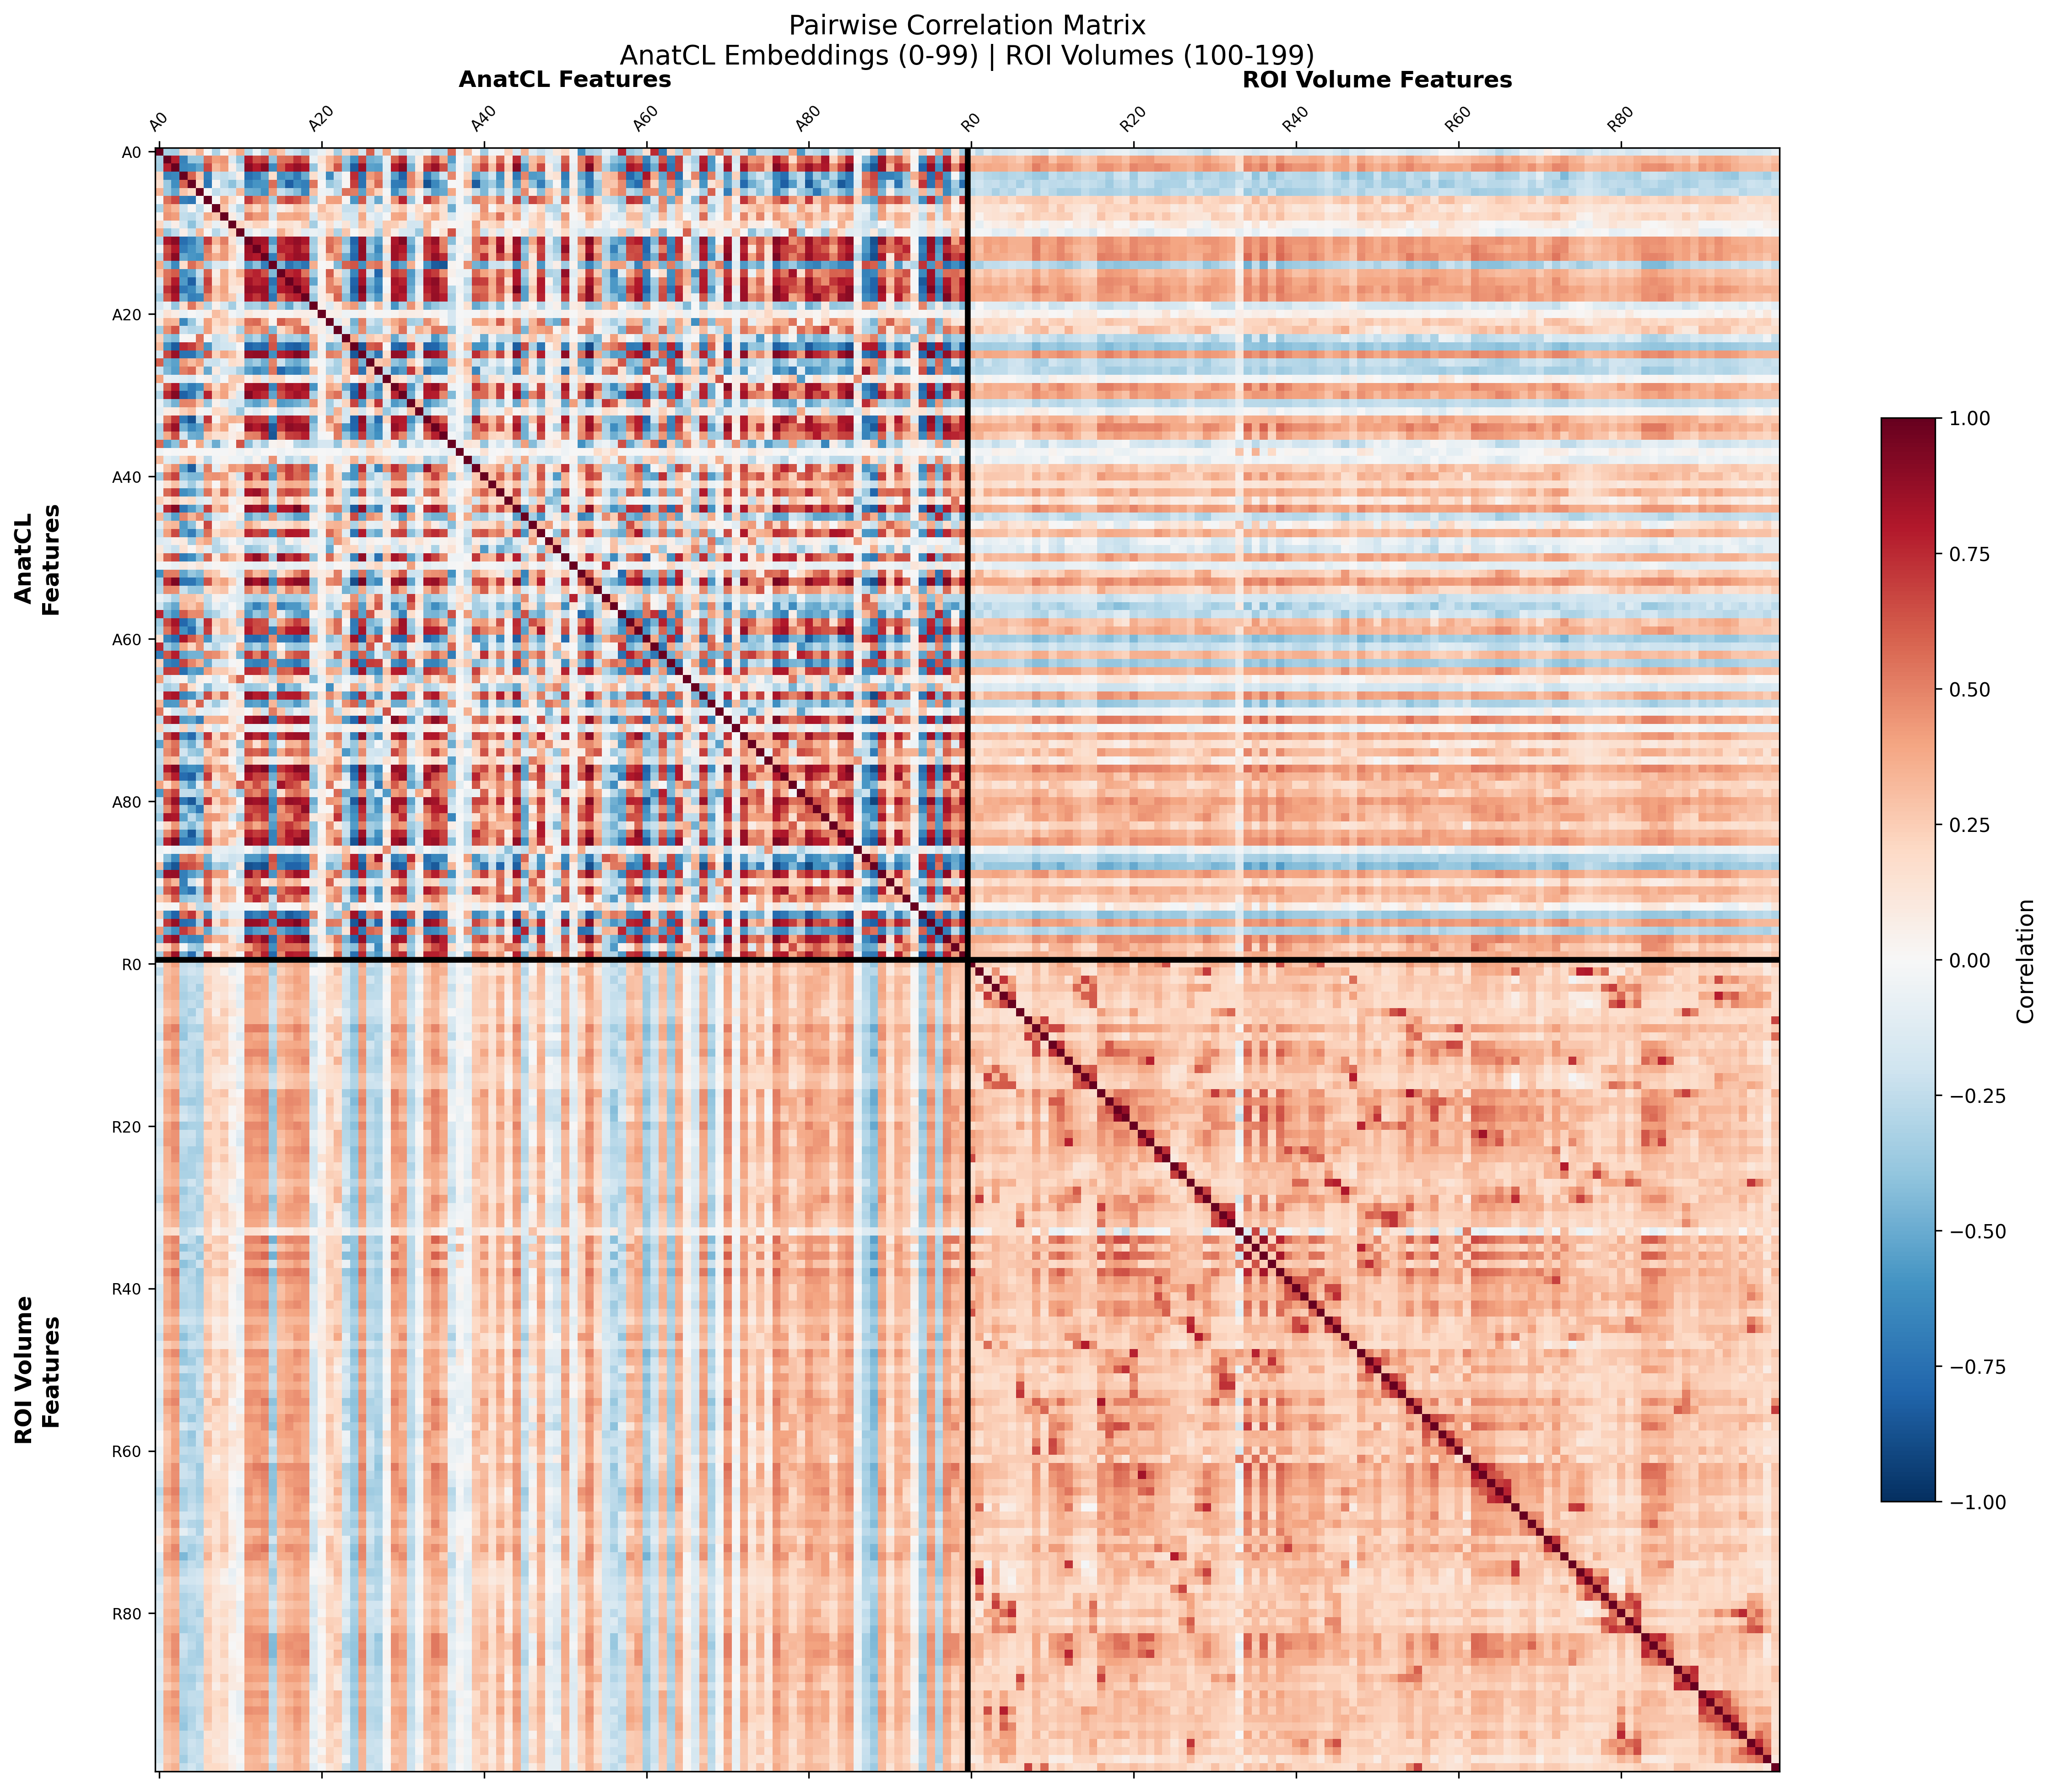

In [6]:
#Correlation Matrix
print("\nCorrelation Matrix:")
print("Shows within-feature-set and cross-method correlations")
display(Image(os.path.join(results_path, 'full_pairwise_correlation_matrix.png')))

Full pairwise matrix shape: (200, 200)
Block analysis:
- AnatCL-AnatCL: (100, 100) features, mean |r| = 0.3919
- ROI volumes-ROI volumes: (100, 100) features, mean |r| = 0.3017
- Cross-correlations: (100, 100) pairs, mean |r| = 0.2620


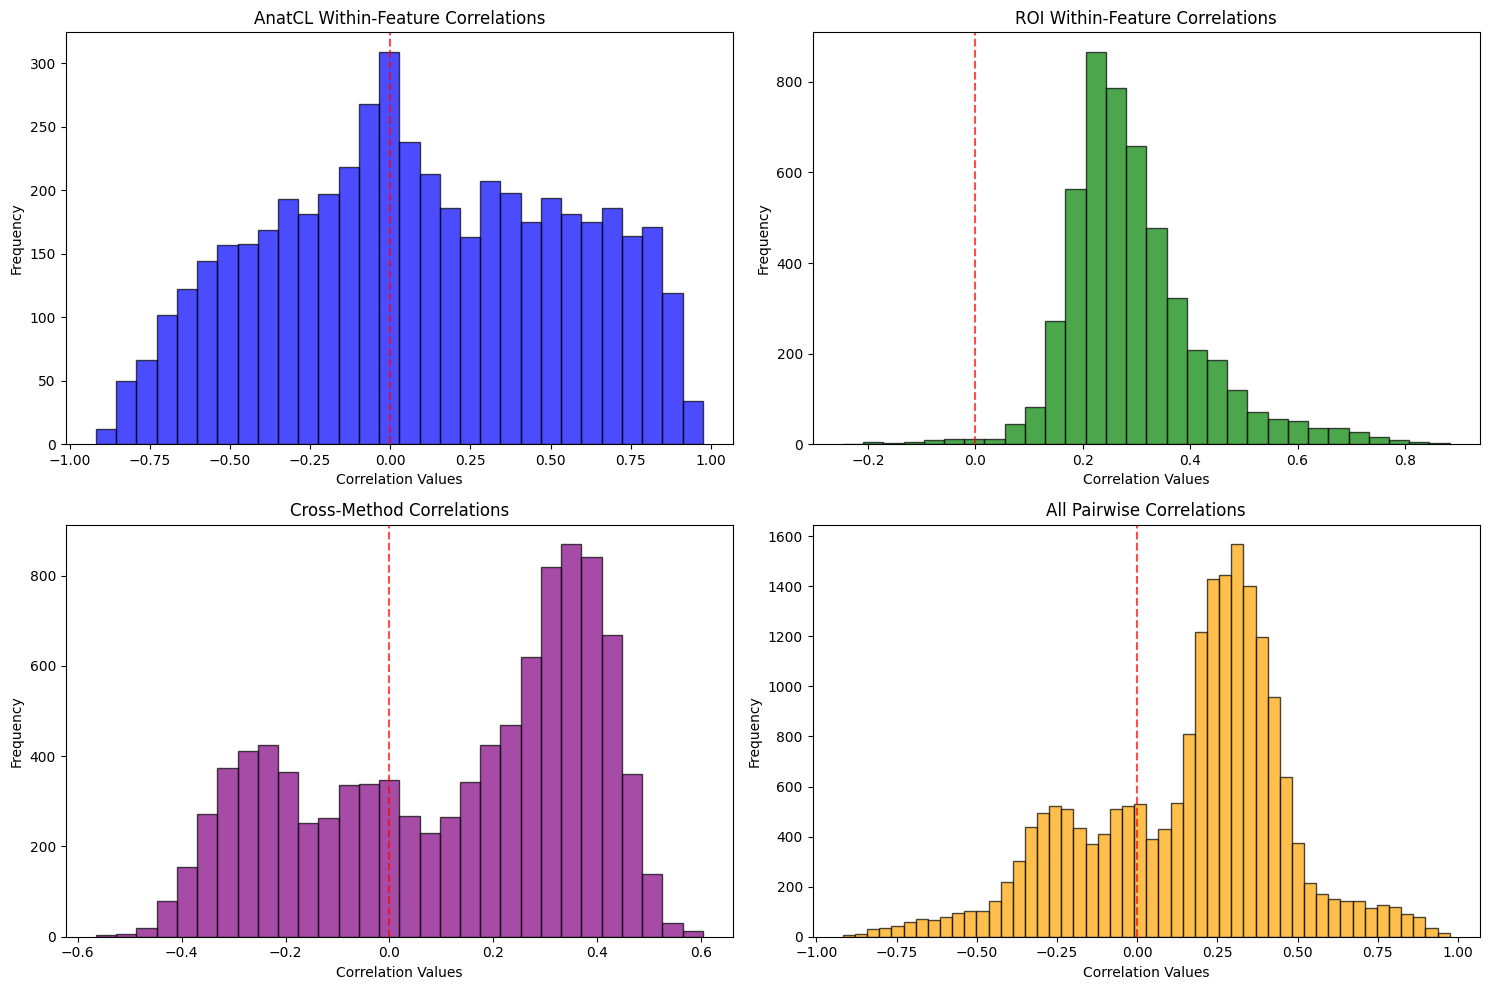

In [7]:
try:
    full_corr_matrix = pd.read_csv(os.path.join(results_path, 'full_pairwise_correlation_matrix.csv'), index_col=0)
    print(f"Full pairwise matrix shape: {full_corr_matrix.shape}")
    
    n_features = full_corr_matrix.shape[0] // 2
    anatcl_block = full_corr_matrix.iloc[:n_features, :n_features]
    roi_block = full_corr_matrix.iloc[n_features:, n_features:]  # Changed from modab_block
    cross_block = full_corr_matrix.iloc[:n_features, n_features:]
    
    print(f"Block analysis:")
    print(f"- AnatCL-AnatCL: {anatcl_block.shape} features, mean |r| = {anatcl_block.abs().values.mean():.4f}")
    print(f"- ROI volumes-ROI volumes: {roi_block.shape} features, mean |r| = {roi_block.abs().values.mean():.4f}")  # Updated
    print(f"- Cross-correlations: {cross_block.shape} pairs, mean |r| = {cross_block.abs().values.mean():.4f}")

finally:
    if 'full_corr_matrix' in locals():
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # AnatCL within-correlations
        anatcl_upper = anatcl_block.values[np.triu_indices_from(anatcl_block.values, k=1)]
        axes[0,0].hist(anatcl_upper, bins=30, alpha=0.7, color='blue', edgecolor='black')
        axes[0,0].set_title('AnatCL Within-Feature Correlations')
        axes[0,0].set_xlabel('Correlation Values')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].axvline(0, color='red', linestyle='--', alpha=0.7)
        
        # ROI volumes within-correlations  
        roi_upper = roi_block.values[np.triu_indices_from(roi_block.values, k=1)]  # Changed from modab_upper
        axes[0,1].hist(roi_upper, bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[0,1].set_title('ROI Within-Feature Correlations')
        axes[0,1].set_xlabel('Correlation Values')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.7)
        
        # Cross-correlations
        cross_values = cross_block.values.flatten()
        axes[1,0].hist(cross_values, bins=30, alpha=0.7, color='purple', edgecolor='black')
        axes[1,0].set_title('Cross-Method Correlations')
        axes[1,0].set_xlabel('Correlation Values')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.7)
        
        # All correlations combined
        all_upper = full_corr_matrix.values[np.triu_indices_from(full_corr_matrix.values, k=1)]
        axes[1,1].hist(all_upper, bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[1,1].set_title('All Pairwise Correlations')
        axes[1,1].set_xlabel('Correlation Values')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].axvline(0, color='red', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()